In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

iris = pd.read_csv('iris.csv')
X = iris.iloc[:, 1:5].values
y = iris['Species'].values
print(iris)
print(X)
print(y)

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

In [2]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

In [3]:
def kmeans(X, k, max_iters=100):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for point in X:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(point)
        new_centroids = [np.mean(cluster, axis=0) for cluster in clusters]
        if np.all([np.allclose(centroids[i], new_centroids[i]) for i in range(k)]):
            break
        
        centroids = new_centroids
    return centroids, clusters

k = 3
centroids, clusters = kmeans(X, k)

In [12]:
def calculate_sse(centroids, clusters):
    sse=0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            sse += euclidean_distance(point, centroids[i])**2
    return sse

def run_kmeans_analysis(funcc,X, k_values):
    results=[]
    for k in k_values:
        centroids, clusters=funcc(X, k)
        sse=calculate_sse(centroids, clusters)
        
        results.append({
            'k': k,
            'sse': sse
        })
    
    return results

k_values=[3,2]
results=run_kmeans_analysis(kmeans,X, k_values)
print("========================================================\n KMEAN ANALYSIS \n========================================================\n")
for result in results:
    print(f"K: {result['k']}")
    print(f"SSE: {result['sse']:.2f}")
    print()

 KMEAN ANALYSIS 

K: 3
SSE: 78.94

K: 2
SSE: 152.37



In [5]:
def select_closest_samples(X, centroids, clusters, n_samples=25):
    selected_samples = []
    selected_labels = []
    
    for i, cluster in enumerate(clusters):
        distances = [euclidean_distance(point, centroids[i]) for point in cluster]
        sorted_indices = np.argsort(distances)[:n_samples]
        selected_samples.extend([cluster[j] for j in sorted_indices])
        for point in [cluster[j] for j in sorted_indices]:
            idx = np.where((X == point).all(axis=1))[0][0]
            selected_labels.append(y[idx])
    
    return np.array(selected_samples), np.array(selected_labels)

X_selected, y_selected = select_closest_samples(X, centroids, clusters)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_selected, y_selected, test_size=0.2)

In [7]:
mask = np.ones(len(X), dtype=bool)
for sample in X_selected:
    idx = np.where((X == sample).all(axis=1))[0][0]
    mask[idx] = False

In [8]:
X_test, y_test = X[mask], y[mask]

## Now its time for Logistic Regression

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)
        y_encoded = np.eye(n_classes)[np.searchsorted(self.classes, y)]
        
        for _ in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = softmax(z)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_encoded))
            db = (1 / n_samples) * np.sum(y_pred - y_encoded, axis=0)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = softmax(z)
        return self.classes[np.argmax(y_pred, axis=1)]


model = LogisticRegression(learning_rate=0.1, num_iterations=1000)
model.fit(X_train, y_train)



### evaluating the model

In [10]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

y_train_pred = model.predict(X_train)
train_accuracy = accuracy(y_train, y_train_pred)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy(y_val, y_val_pred)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy(y_test, y_test_pred)
print("========================================================\n LOGISTIC REGRESSION ANALYSIS \n========================================================\n")
print(f"TRAIN accuracy: {train_accuracy:.4f}")
print(f"VALIDATION accuracy: {val_accuracy:.4f}")
print(f"TEST acuuracy: {test_accuracy:.4f}")

 LOGISTIC REGRESSION ANALYSIS 

TRAIN accuracy: 0.9833
VALIDATION accuracy: 1.0000
TEST acuuracy: 0.9740


### relevent graph

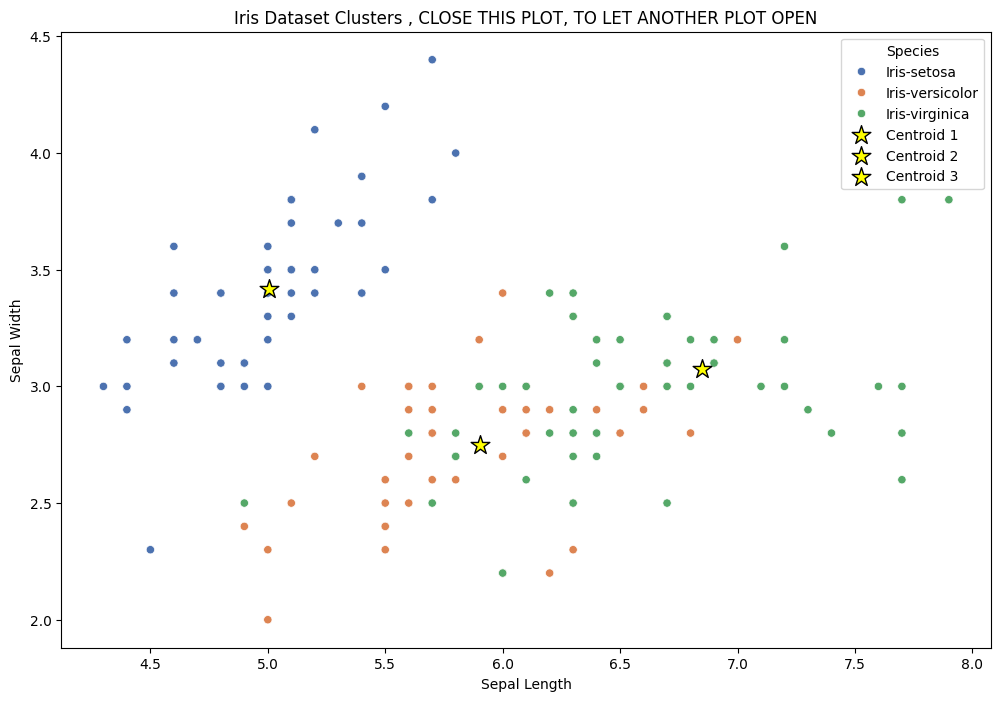

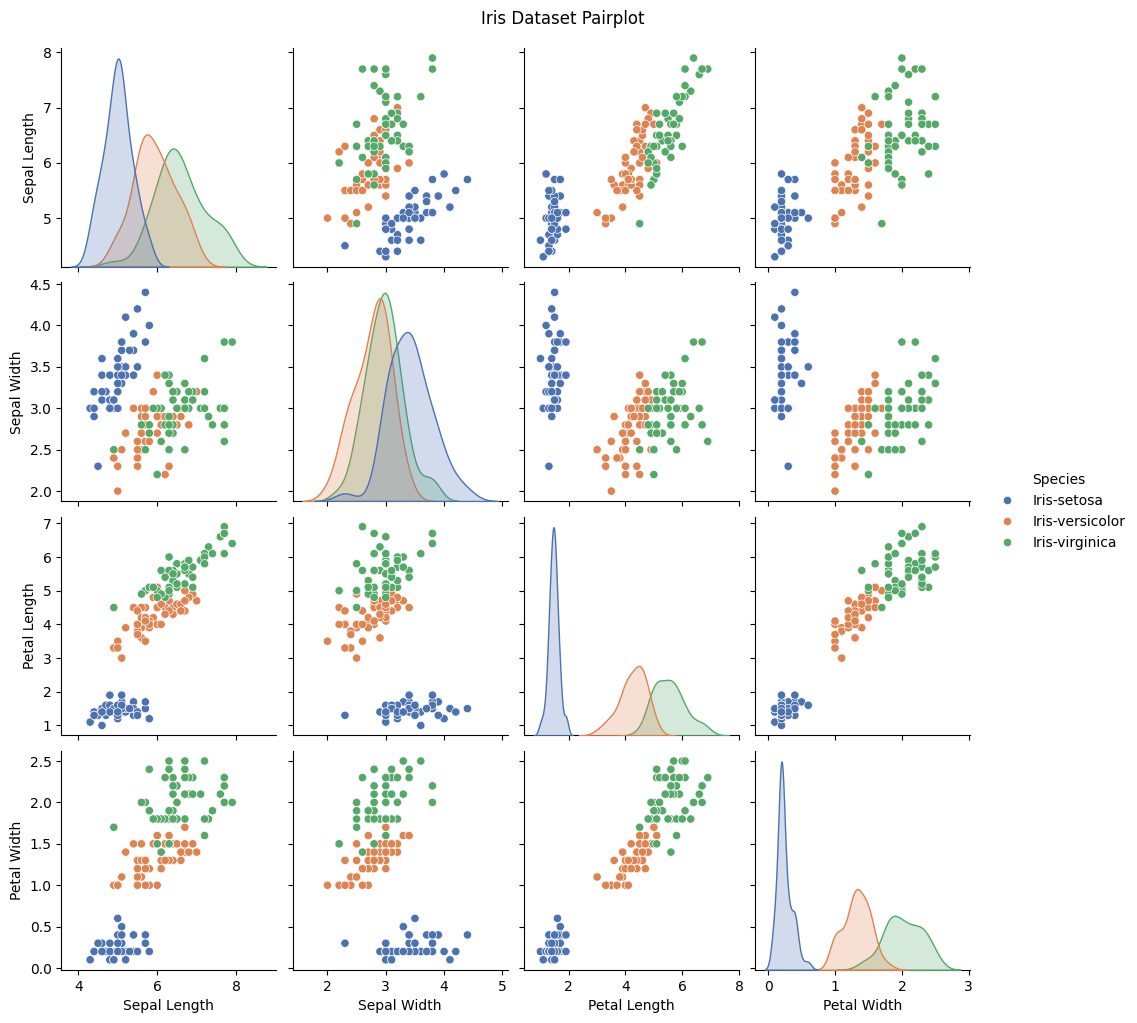

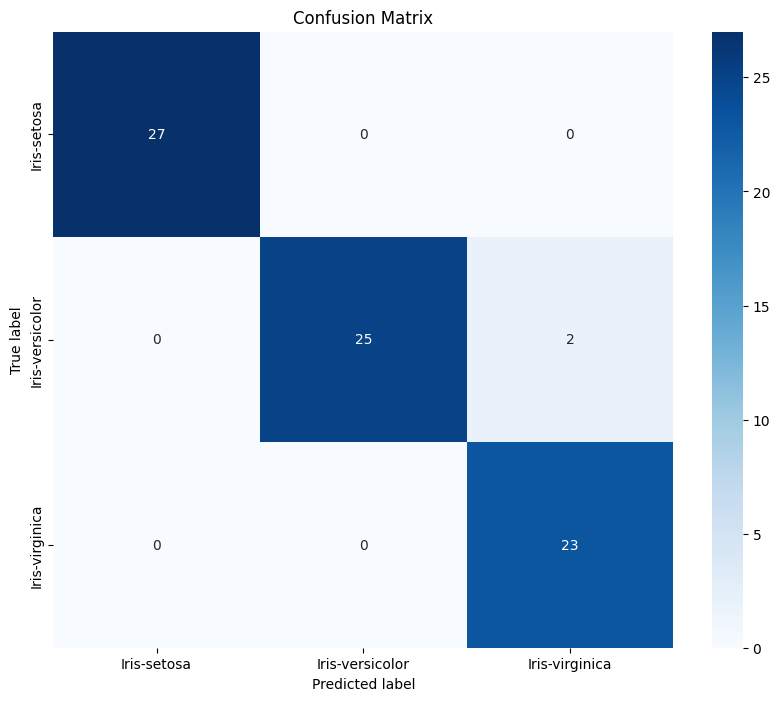

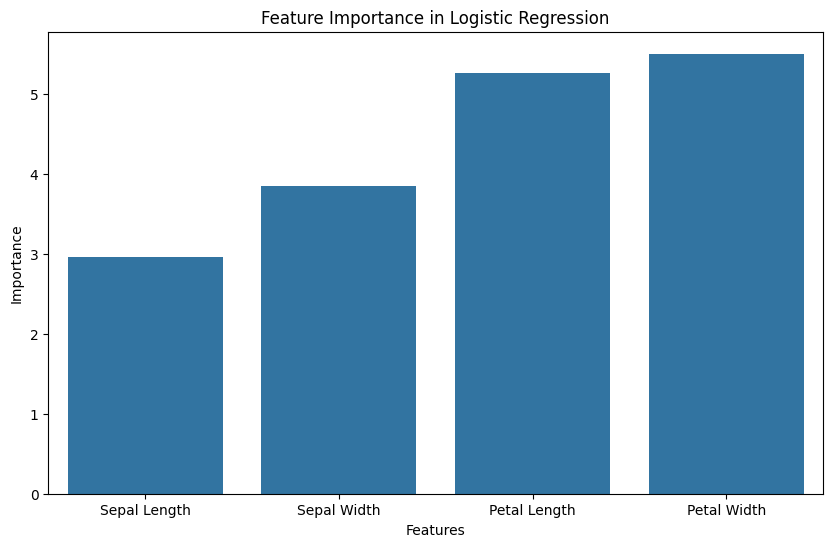

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='deep', legend='full')
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], s=200, c='yellow', marker='*', edgecolor='black', label=f'Centroid {i+1}')
plt.title('Iris Dataset Clusters , CLOSE THIS PLOT, TO LET ANOTHER PLOT OPEN')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(title='Species')
plt.show()

iris_df = pd.DataFrame(X, columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
iris_df['Species'] = y
sns.pairplot(iris_df, hue='Species', palette='deep')
plt.suptitle('Iris Dataset Pairplot', y=1.02)
plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=classes, columns=classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test, y_test_pred, model.classes)

feature_importance = np.sum(np.abs(model.weights), axis=1)
feature_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=feature_importance)
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()